# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TR-SLD_v1-0b.csv'
DATA_FRMT = 'wav'
DATASET = 'SLD_v1-0b'
GROUP = 'train'
RANDOM_SAMPLES = 500  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path   label
0  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch
1  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch
2  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch
3  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch
4  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
34643  train/fr\fr_m_46787\fr_m_46787__rmx__r16000__n...      french   
34046  train/fr\fr_m_3c5d7\fr_m_3c5d7__rmx__r16000__n...      french   
48944  train/pt\pt_m_4f379\pt_m_4f379__rmx__r16000__n...  portuguese   
18536  train/en\en_f_cb905\en_f_cb905__rmx__r16000__n...     english   
21825  train/en\en_m_3a8f3\en_m_3a8f3__rmx__r16000__n...     english   
43856  train/pt\pt_f_81c87\pt_f_81c87__rmx__r16000__n...  portuguese   
64689  train/es\es_m_f16e9\es_m_f16e9__rmx__r16000__n...     spanish   
4522   train/de\de_f_bc4b6\de_f_bc4b6__rmx__r16000__n...      deutch   
1662   train/de\de_f_2825f\de_f_2825f__rmx__r16000__n...      deutch   
32555  train/fr\fr_f_e836d\fr_f_e836d__rmx__r16000__n...      french   
47654  train/pt\pt_m_27085\pt_m_27085__rmx__r16000__n...  portuguese   
43538  train/pt\pt_f_75573\pt_f_75573__rmx__r16000__n...  portuguese   
28554  train/fr\fr_f_799c7\fr_f_799c7__rmx__r16000__n...      french   
42178  train/pt\pt_f_6a030\pt_f_6a030__rmx__r16000__n...  portuguese   
23087  train/en\en_m_65733\en_m_65733__rmx__r16000__n...     english   
59633  train/es\es_m_406bb\es_m_406bb__rmx__r16000__n...     spanish   
38479  train/fr\fr_m_a93c8\fr_m_a93c8__rmx__r16000__n...      french   
37806  train/fr\fr_m_97ed5\fr_m_97ed5__rmx__r16000__n...      french   
28268  train/fr\fr_f_77c6a\fr_f_77c6a__rmx__r16000__n...      french   
45403  train/pt\pt_f_f587a\pt_f_f587a__rmx__r16000__n...  portuguese   
49466  train/pt\pt_m_6c435\pt_m_6c435__rmx__r16000__n...  portuguese   
44867  train/pt\pt_f_b639c\pt_f_b639c__rmx__r16000__n...  portuguese   
1267   train/de\de_f_26ddc\de_f_26ddc__rmx__r16000__n...      deutch   
19685  train/en\en_f_fff98\en_f_fff98__rmx__r16000__n...     english   
61907  train/es\es_m_7e1c8\es_m_7e1c8__rmx__r16000__n...     spanish   
34830  train/fr\fr_m_46787\fr_m_46787__rmx__r16000__n...      french   
64913  train/es\es_m_f16e9\es_m_f16e9__rmx__r16000__n...     spanish   
54102  train/es\es_f_53b55\es_f_53b55__rmx__r16000__n...     spanish   
26901  train/fr\fr_f_20123\fr_f_20123__rmx__r16000__n...      french   
10716  train/de\de_m_ab485\de_m_ab485__rmx__r16000__n...      deutch   
53299  train/es\es_f_2b24d\es_f_2b24d__rmx__r16000__n...     spanish   
42434  train/pt\pt_f_6a030\pt_f_6a030__rmx__r16000__n...  portuguese   
25324  train/en\en_m_d2f13\en_m_d2f13__rmx__r16000__n...     english   
16648  train/en\en_f_7701e\en_f_7701e__rmx__r16000__n...     english   
30723  train/fr\fr_f_a99b5\fr_f_a99b5__rmx__r16000__n...      french   
38716  train/fr\fr_m_a93c8\fr_m_a93c8__rmx__r16000__n...      french   
15957  train/en\en_f_5dff2\en_f_5dff2__rmx__r16000__n...     english   
40552  train/pt\pt_f_37eb7\pt_f_37eb7__rmx__r16000__n...  portuguese   
46825  train/pt\pt_m_0c95f\pt_m_0c95f__rmx__r16000__n...  portuguese   
46500  train/pt\pt_m_0c95f\pt_m_0c95f__rmx__r16000__n...  portuguese   

       sample_rate                                        time_series  \
34643        16000  [-93421568, -127893504, -160268288, -164397056...   
34046        16000  [-1526, -1123, -981, -819, 365, 1805, 2734, 28...   
48944        16000  [3559, 2003, -2418, -2561, -1376, -2579, -1330...   
18536        16000  [4958, 8862, 7270, 663, -386, 730, -5219, -996...   
21825        16000  [-1314, -6082, -9127, -8255, -4911, -1964, -36...   
43856        16000  [554, 344, -44, 781, 1045, 561, 1105, 1394, 91...   
64689        16000  [-41, -40, -43, -48, -48, -46, -49, -52, -44, ...   
4522         16000  [22, 22, -5, -13, -15, -16, -32, -25, 5, -6, -...   
1662         16000  [2181, 2085, 2704, 3414, 3774, 3836, 3897, 425...   
32555        16000  [537, -386, -756, 340, 755, 130, -399, -590, -...   
47654        16000  [-12, -19, -16, -4, 2, -2, -14, -23, -17, 6, 3...   
43538        16000  [-4015, -1009, 1129, 2388, -2563, -851, 4625, ...   
28554        16000  [16515072, 7962624, -3506176, -11337728, -8945...   
42178        16000  [1093, 570, -859, -1391, -530, 428, 508, 133, ...   

In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True) 


In [10]:
data.head()

file_path   label  \
0  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   
1  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   
2  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   
3  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   
4  train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  de_f_0809f__rmx__r16000_           None           None  ambiance     None   
1  de_f_0809f__rmx__r16000_           None           None  ambiance     None   
2  de_f_0809f__rmx__r16000_           None           None  ambiance     None   
3  de_f_0809f__rmx__r16000_           None           None  ambiance     None   
4  de_f_0809f__rmx__r16000_           None           None  ambiance     None   

   augmented_data  
0            True  
1            True  
2            True  
3            True  
4            True

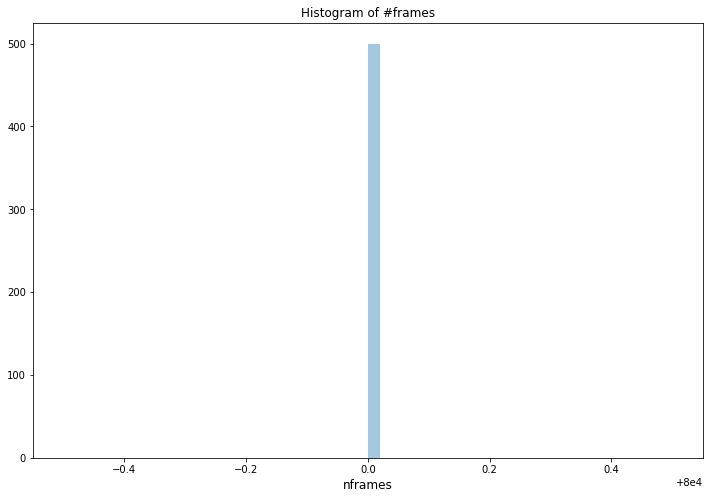

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

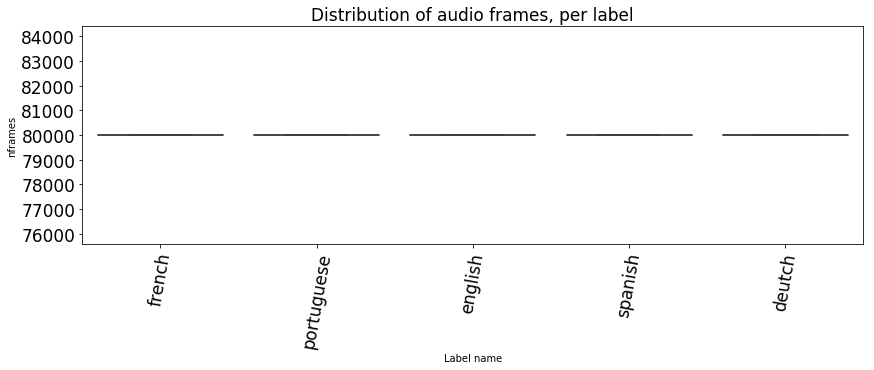

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path   label  \
0     train/de\de_f_0809f\de_f_0809f__rmx__r16000__n...  deutch   
8725  train/de\de_m_4d099\de_m_4d099__rmx__r16000__n...  deutch   
8726  train/de\de_m_4d099\de_m_4d099__rmx__r16000__n...  deutch   
8727  train/de\de_m_4d099\de_m_4d099__rmx__r16000__n...  deutch   
8728  train/de\de_m_4d099\de_m_4d099__rmx__r16000__n...  deutch   

                     file_name speed_changing pitch_changing noise_add  \
0     de_f_0809f__rmx__r16000_           None           None  ambiance   
8725  de_m_4d099__rmx__r16000_           None           50.0      None   
8726  de_m_4d099__rmx__r16000_           None           50.0      None   
8727  de_m_4d099__rmx__r16000_           None           50.0      None   
8728  de_m_4d099__rmx__r16000_           0.80           None      None   

     low_pass  augmented_data  
0        None            True  
8725     None            True  
8726     None            True  
8727     None            True  
8728     None            True

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

13097

Total number of labels in training data :  5
Labels are :  ['deutch' 'english' 'french' 'portuguese' 'spanish']


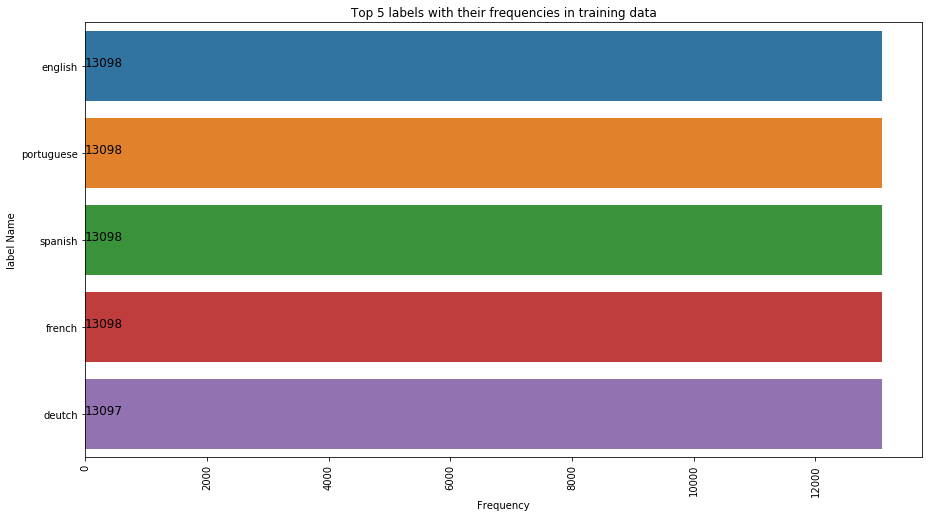

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por gênero

In [22]:
temp = data['gender'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Gender')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por contagem de locutores

In [23]:
speakers_count = dict()
for lang in data['label']:
    speakers_count[lang] = 0
counted = set()
for lang, fname in zip(data['label'], data['file_name']):
    if fname not in counted:
        speakers_count[lang] += 1
        counted.add(fname)
        
df_spk = pandas.DataFrame(data=list(zip(speakers_count.keys() ,speakers_count.values())), 
                          columns=['label', 'Speakers (count)'])
df_spk.head()

label  Speakers (count)
0      deutch                28
1     english                28
2      french                28
3  portuguese                28
4     spanish                28

In [24]:
temp = df_spk['Speakers (count)']
labels = df_spk['label']
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Speaker (count)')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por locutores

count
label  file_name                      
deutch de_f_0809f__rmx__r16000_    486
       de_f_1996a__rmx__r16000_    466
       de_f_26ddc__rmx__r16000_    489
       de_f_2825f__rmx__r16000_    469
       de_f_40479__rmx__r16000_    446

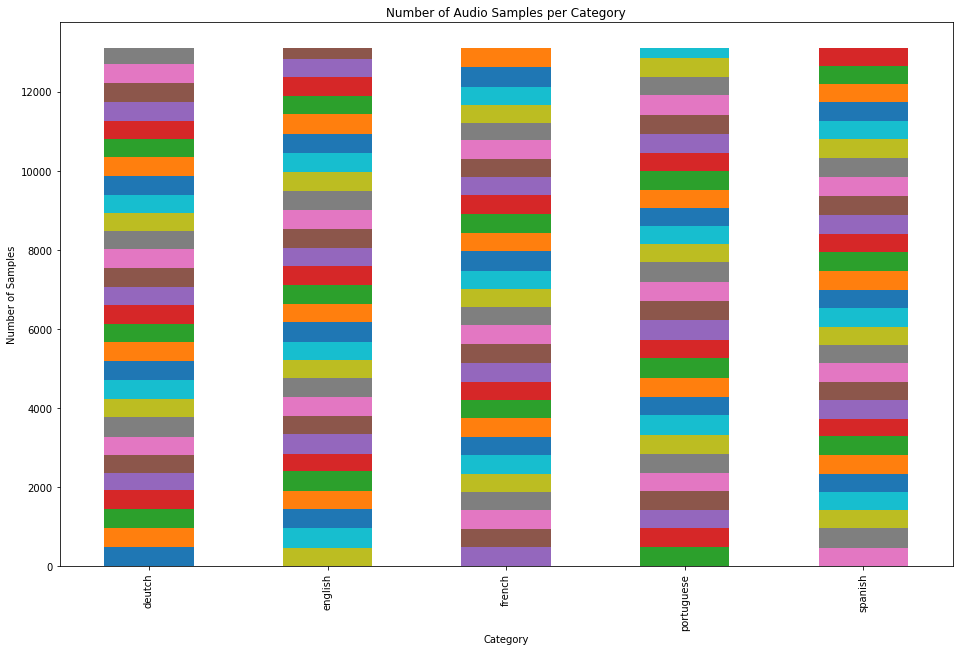

In [25]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['file_name']), 
                        columns=['count', 'label', 'file_name'])
category_group = temp.groupby(['label', 'file_name']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
plot.get_legend().remove()
category_group.head()

## Instâncias por idioma e gênero

count
label      gender       
deutch     f        6592
           m        6505
english    f        6630
           m        6468
french     f        6562
           m        6536
portuguese f        6220
           m        6878
spanish    f        6520
           m        6578

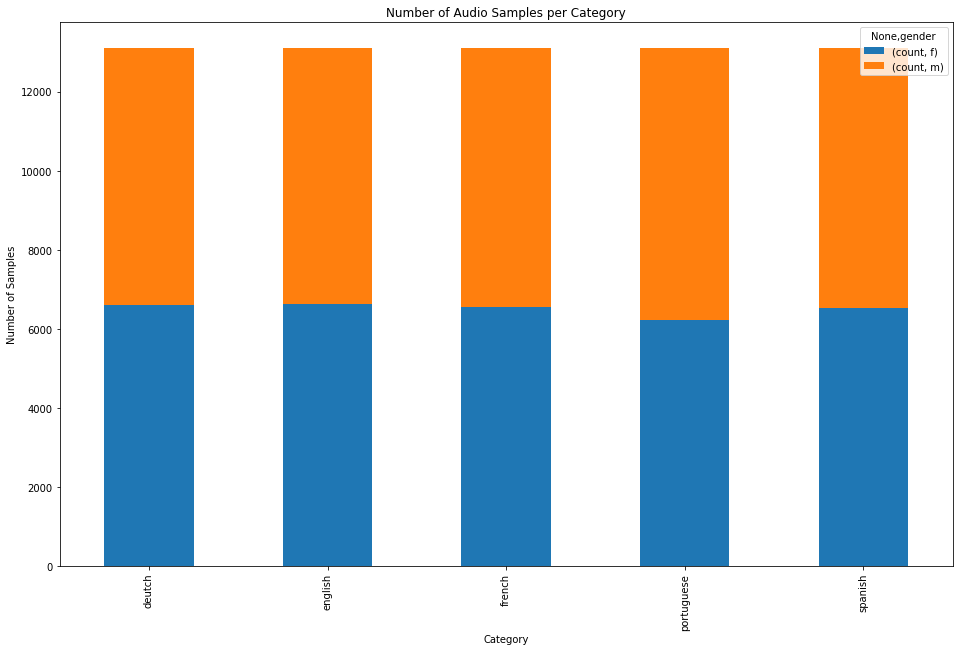

In [26]:
temp = pandas.DataFrame(zip(data['file_path'], data['label'], data['gender']), 
                        columns=['count', 'label', 'gender'])
category_group = temp.groupby(['label', 'gender']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

## Instâncias por _data augmentation_

In [27]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
deutch     False             599
           True            12498
english    False             607
           True            12491
french     False             619
           True            12479
portuguese False             608
           True            12490
spanish    False             598
           True            12500

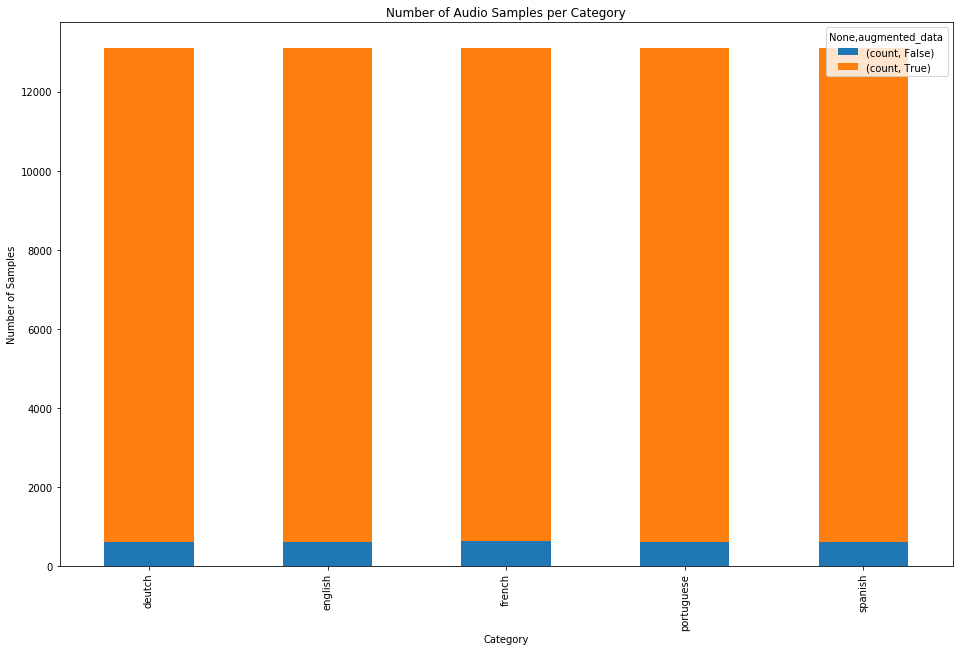

In [28]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label   augmented_data                                                     
deutch  False             599               0               0          0   
        True            12498            5059            4960       2479   
english False             607               0               0          0   
        True            12491            4944            5027       2520   
french  False             619               0               0          0   

                        low_pass  
label   augmented_data            
deutch  False                  0  
        True                   0  
english False                  0  
        True                   0  
french  False                  0

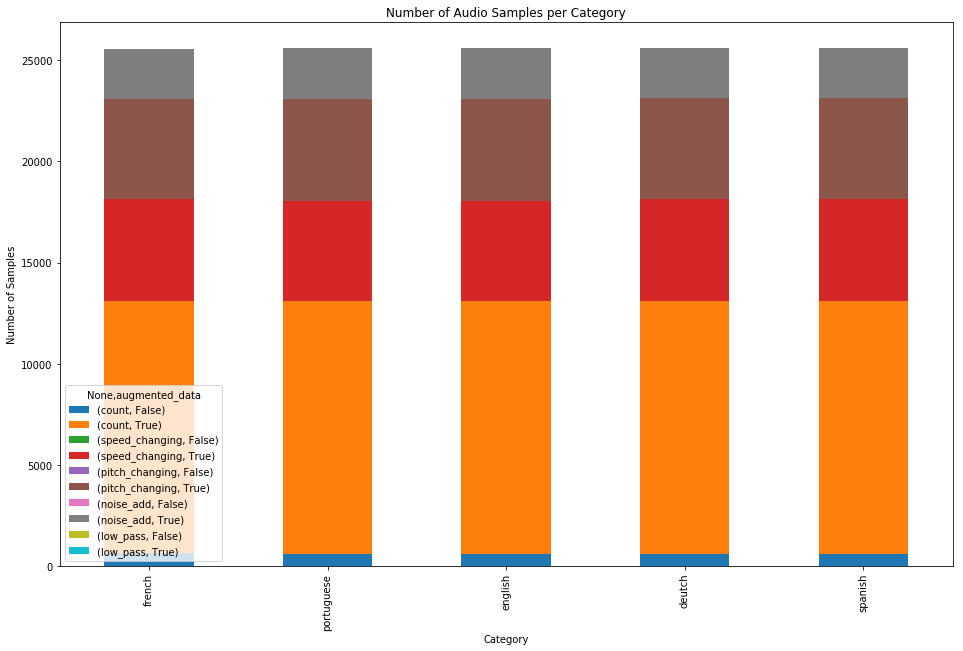

In [29]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

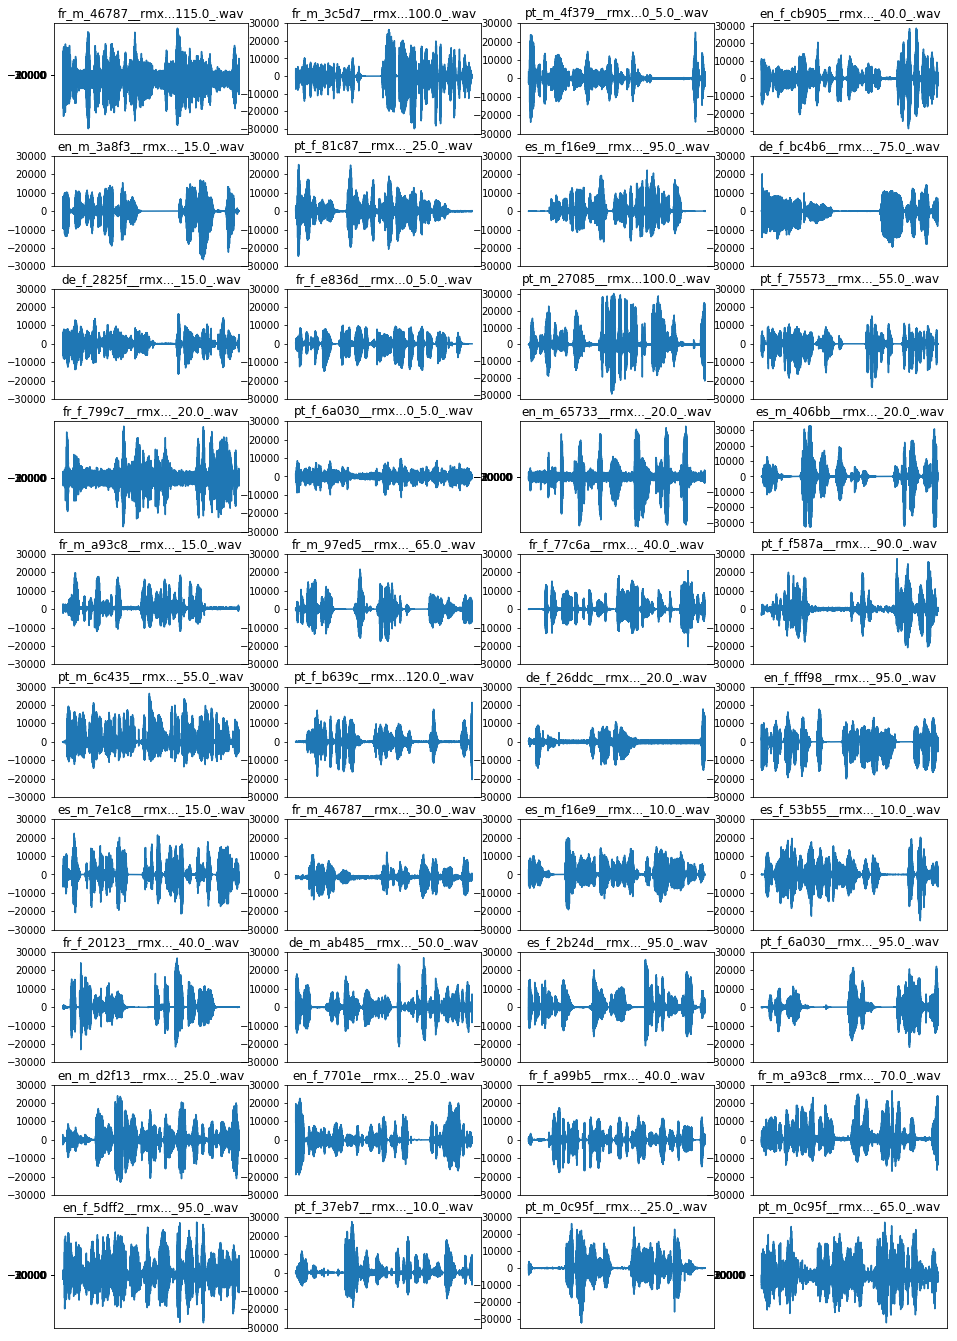

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
    ax[i//4, i%4].get_yaxis().set_ticks([-30000, -20000, -10000, 0, 10000, 20000, 30000])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [31]:
sr, b = wavfile.read(data['file_path'][0])

In [32]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

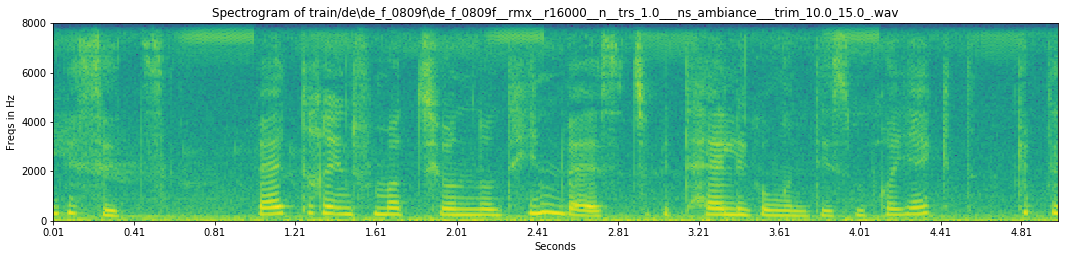

In [33]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [34]:
print("Size of training data", data.shape)

Size of training data (65489, 9)


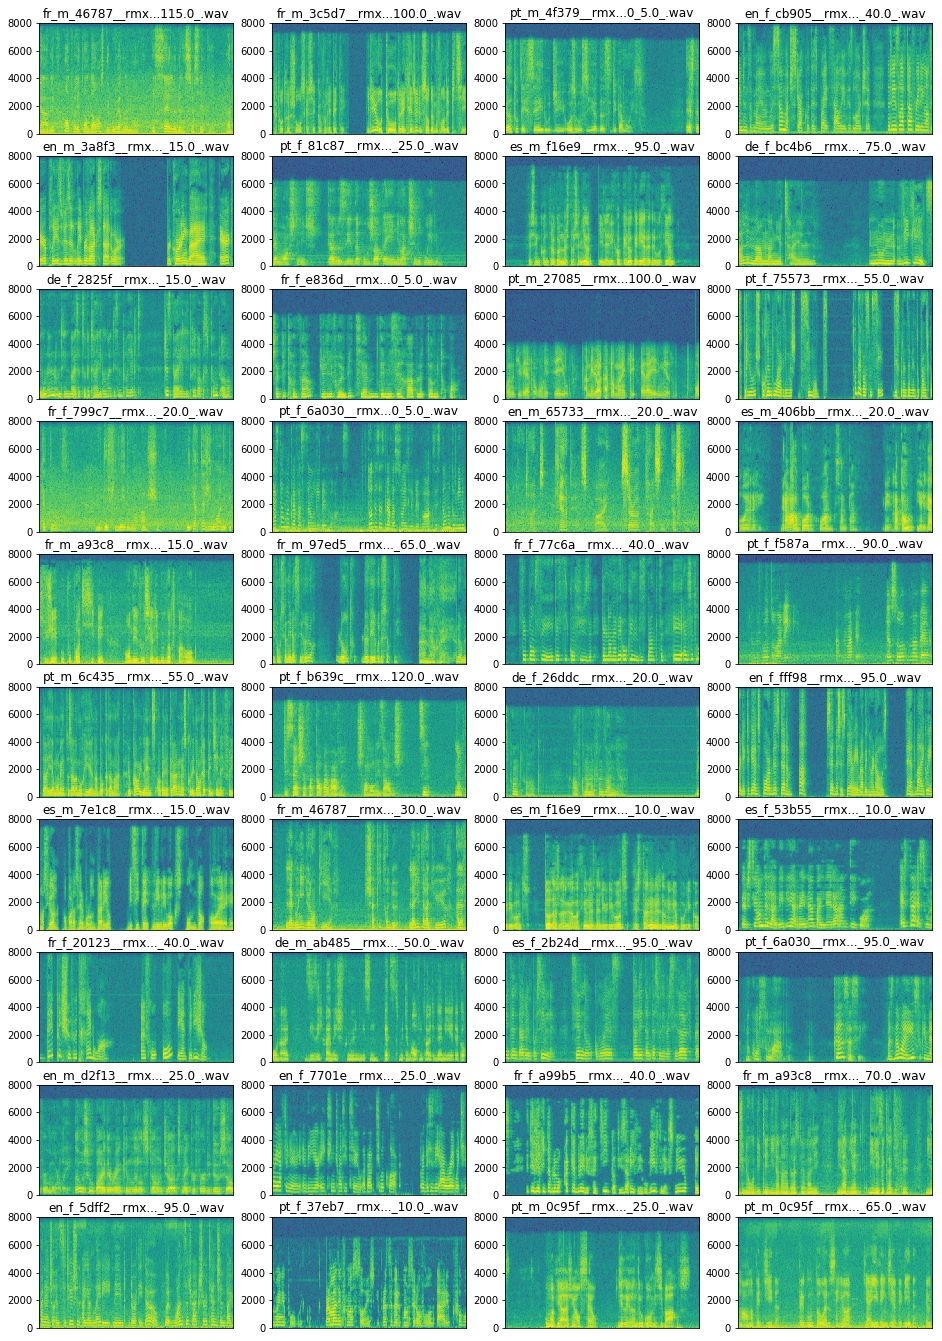

In [35]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [36]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

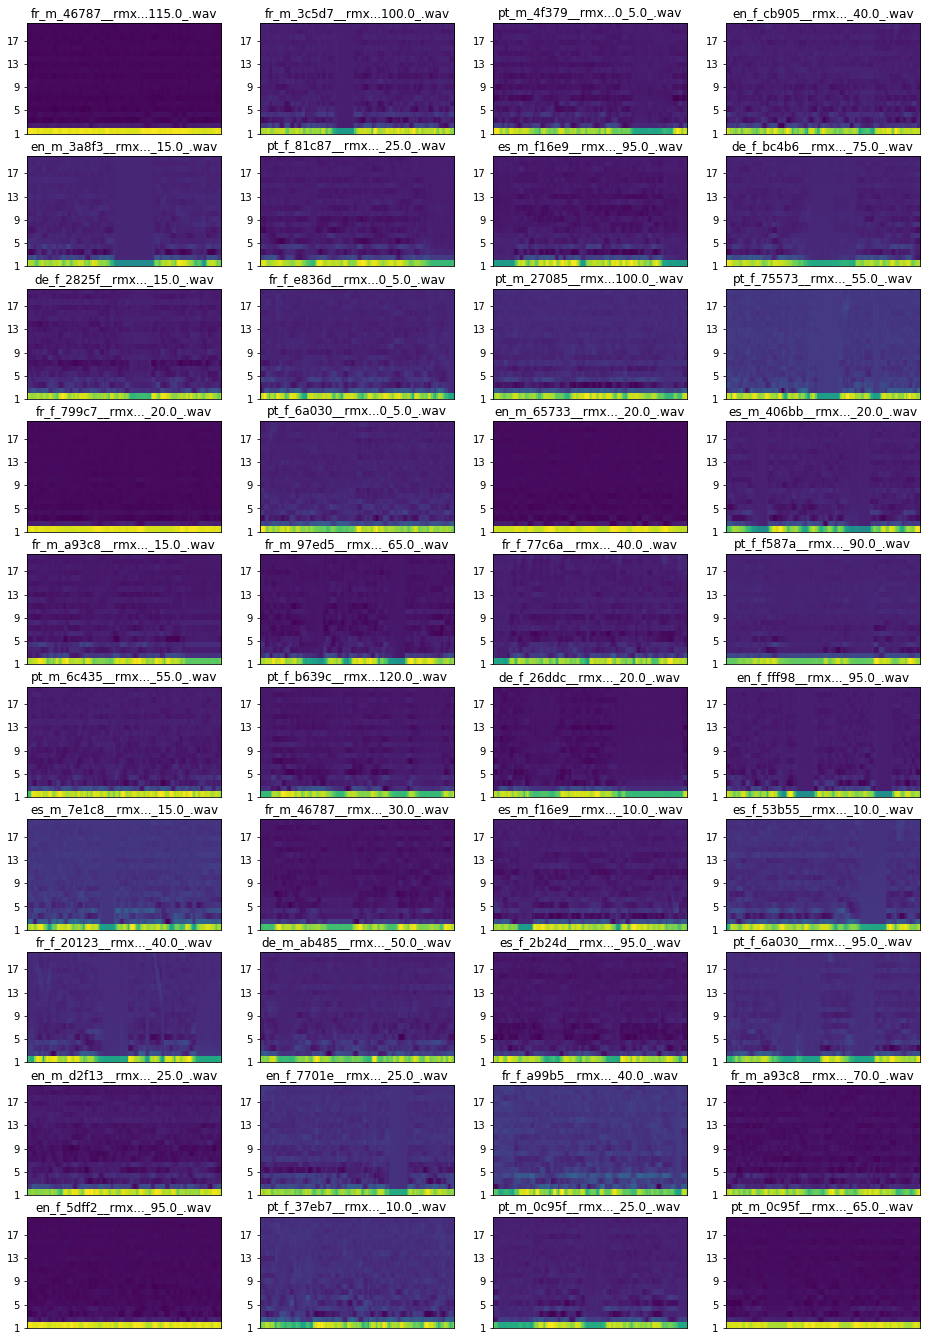

In [37]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [38]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

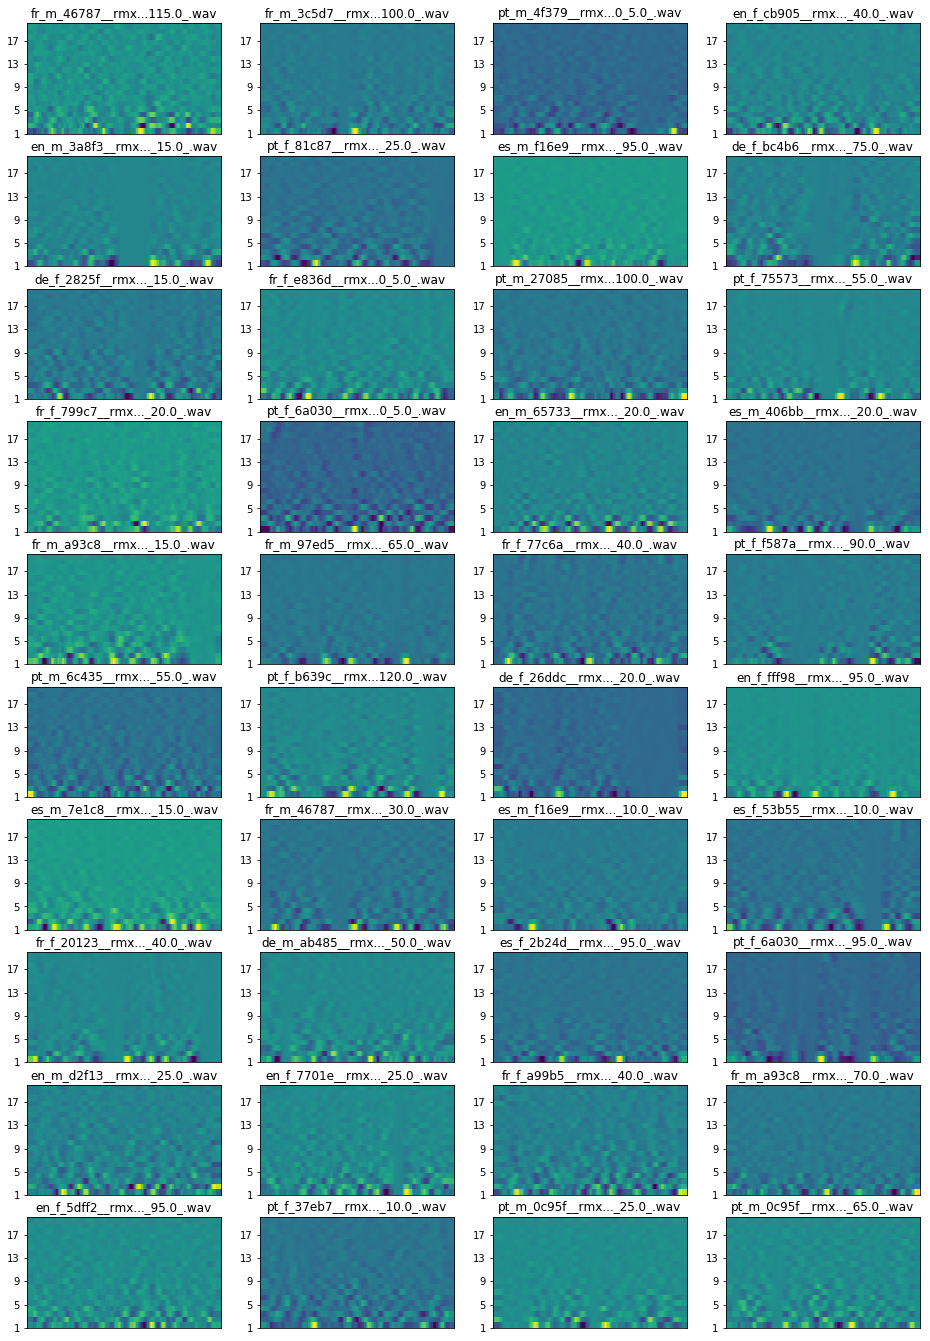

In [39]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [40]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

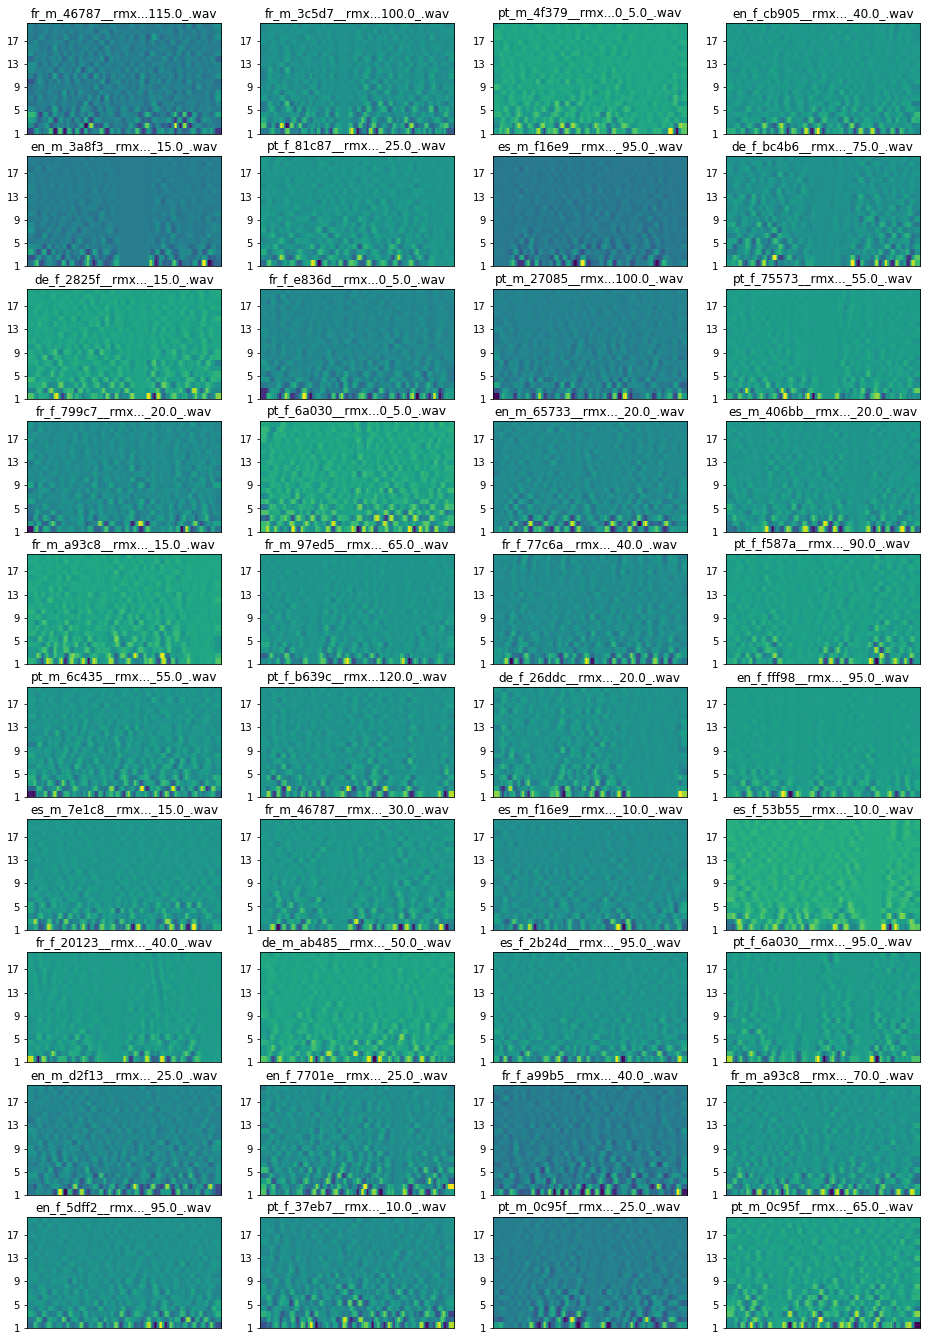

In [41]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [42]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

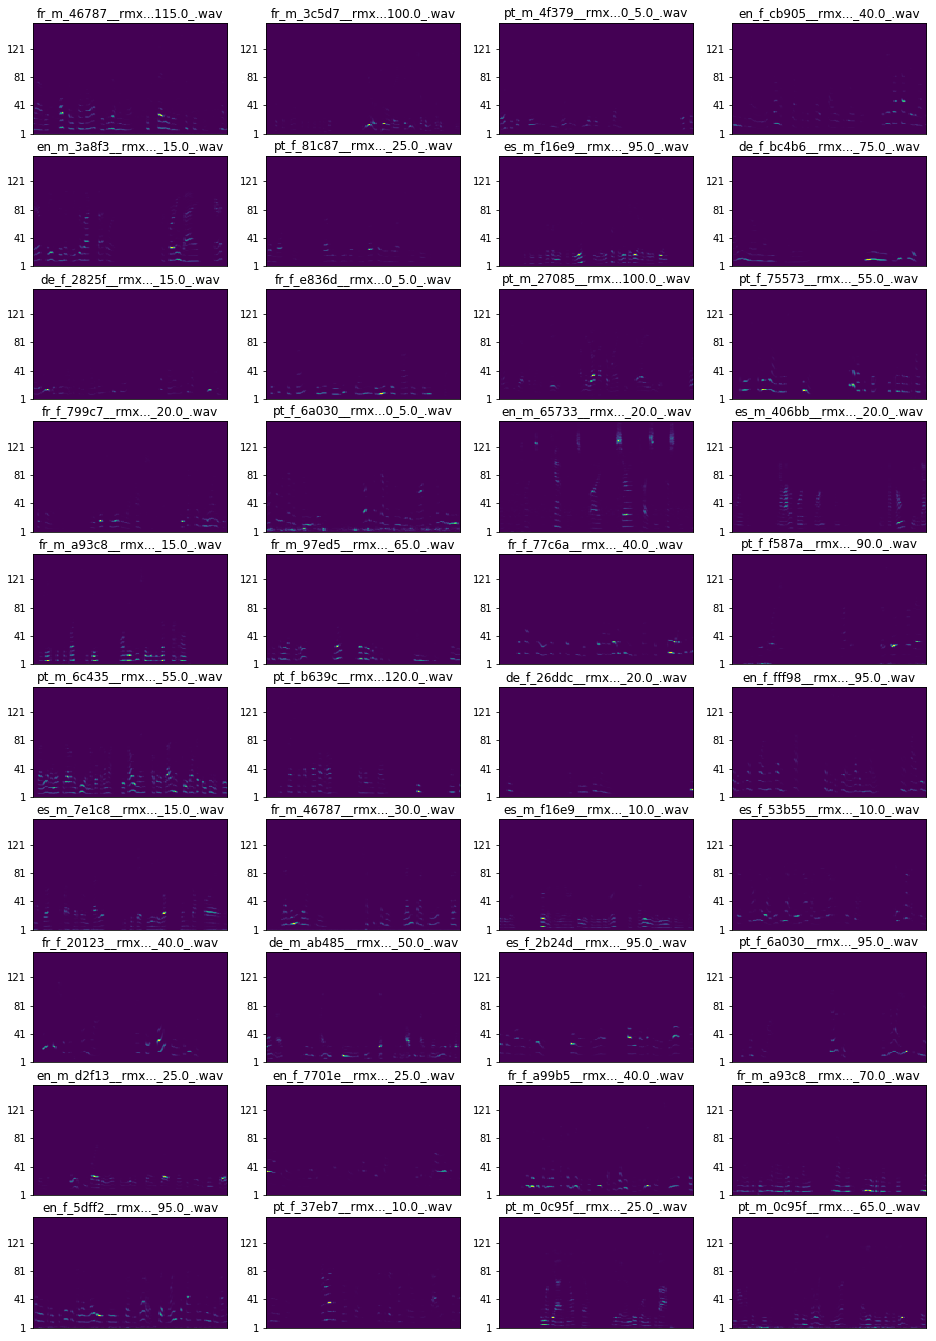

In [43]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  